In [7]:
%reload_ext autoreload
%autoreload 2

import os
os.chdir(f"/home/{os.getlogin()}/watttime-python-client-aer-algo")

import math
import numpy as np
import pandas as pd
import datetime
import pytz
import seaborn as sns
from datetime import datetime, timedelta
import concurrent.futures

from watttime import WattTimeForecast, WattTimeHistorical

import optimizer.s3 as s3u
import evaluation.eval_framework as efu

import watttime.shared_anniez.alg.optCharger as optC
import watttime.shared_anniez.alg.moer as Moer


username = os.getenv("WATTTIME_USER")
password = os.getenv("WATTTIME_PASSWORD")

actual_data = WattTimeHistorical(username, password)
hist_data = WattTimeForecast(username, password)

s3 = s3u.s3_utils()
key = '20240726_1k_synth_users_163_days.csv'
generated_data = s3.load_csvdataframe(file=key)

# Synthetic User Data

In [11]:
regions = ['CAISO_NORTH',
 #'SPP_TX',
 #'ERCOT_EASTTX',
 #'FPL',
 #'SOCO',
 #'PJM_CHICAGO',
 #'LDWP',
 #'PJM_DC',
 #'NYISO_NYC'
]
region = regions[0]

synth_data = generated_data.copy(deep=True)
synth_data["plug_in_time"] = pd.to_datetime(synth_data["plug_in_time"])
synth_data["unplug_time"] = pd.to_datetime(synth_data["unplug_time"])

# Cached version of the get_*_data functions

In [12]:
%%time

def precache_actual_data(synth_data, regions):
    distinct_dates = [
        datetime.strptime(date, "%Y-%m-%d").date()
        for date in synth_data["distinct_dates"].unique().tolist()
    ]
    all_dates_regions = [(date, region) for date in distinct_dates for region in regions]

    def get_actual_data_for_region_date(date, region):
        start = pd.to_datetime(date)
        end = start + pd.Timedelta("2d")  
        return (region, date, actual_data.get_historical_pandas(
            start - pd.Timedelta("9h"),
            end + pd.Timedelta("9h"),
            region,
        ))

    with concurrent.futures.ThreadPoolExecutor(max_workers=100) as executor:
        result = executor.map(get_actual_data_for_region_date,
            [date for (date, region) in all_dates_regions], 
            [region for (date, region) in all_dates_regions]
            )
    result = list(result)

    return {(region, date): data for (region, date, data) in result}

HISTORICAL_ACTUAL_CACHE = precache_actual_data(synth_data, regions)

CPU times: user 53.8 s, sys: 436 ms, total: 54.3 s
Wall time: 11 s


In [13]:
%%time

def precache_fcst_data(synth_data, regions):
    distinct_dates = [
        datetime.strptime(date, "%Y-%m-%d").date()
        for date in synth_data["distinct_dates"].unique().tolist()
    ]
    all_dates_regions = [(date, region) for date in distinct_dates for region in regions]

    def get_fsct_data_for_region_date(date, region):
        start = pd.to_datetime(date)
        end = (pd.to_datetime(date) + pd.Timedelta("1d"))      
        return  (region, date,  hist_data.get_historical_forecast_pandas(
            start - pd.Timedelta("9h"),
            end + pd.Timedelta("9h"),
            region,
        ))

    with concurrent.futures.ThreadPoolExecutor(max_workers=100) as executor:
        result = executor.map(get_fsct_data_for_region_date,
            [date for (date, region) in all_dates_regions], 
            [region for (date, region) in all_dates_regions]
            )
    result = list(result)
    return {(region, date): data for (region, date, data) in result}

HISTORICAL_FORECAST_CACHE = precache_fcst_data(synth_data, regions)


 Warnings Returned: {'region': 'CAISO_NORTH', 'signal_type': 'co2_moer', 'horizon_hours': 24, 'start': Timestamp('2023-05-17 15:00:00+0000', tz='UTC'), 'end': Timestamp('2023-05-18 14:55:00+0000', tz='UTC')} {'data_point_period_seconds': 300, 'region': 'CAISO_NORTH', 'signal_type': 'co2_moer', 'units': 'lbs_co2_per_mwh', 'warnings': [{'type': 'MISSING_DATA', 'message': 'You made a valid request, but we have some datapoints missing. This can happen for a variety of reasons. If the data is less than a week old, we will most likely fill in this data soon. If it is older than that, we are missing enough important grid data during this time period that we are not able to generate an accurate estimate'}], 'model': {'date': '2023-03-01'}, 'generated_at_period_seconds': 300}

 Warnings Returned: {'region': 'CAISO_NORTH', 'signal_type': 'co2_moer', 'horizon_hours': 24, 'start': Timestamp('2023-05-31 15:00:00+0000', tz='UTC'), 'end': Timestamp('2023-06-01 14:55:00+0000', tz='UTC')} {'data_point

---

In [16]:
def get_historical_fcst_data_cached(plug_in_time, horizon, region):
    time_zone = efu.get_timezone_from_dict(region)
    plug_in_time_utc = pd.Timestamp(efu.convert_to_utc(plug_in_time, time_zone))
    date = plug_in_time.date()
    if (region, date) not in HISTORICAL_FORECAST_CACHE.keys():
        print(type(date), date)
        start = pd.to_datetime(date)
        end = (pd.to_datetime(date) + pd.Timedelta("1d"))      
        HISTORICAL_FORECAST_CACHE[(region, date)] = hist_data.get_historical_forecast_pandas(
            start - pd.Timedelta("9h"),
            end + pd.Timedelta("9h"),
            region,
        )
    cache = HISTORICAL_FORECAST_CACHE[(region, date)]
        
    # make this match efu.get_historical_fsct_data
    generated_at_times = cache["generated_at"].unique()
    generated_at = max([t for t in generated_at_times if t < plug_in_time_utc])
    df = cache[cache["generated_at"] == generated_at].copy()
    return df.iloc[:math.ceil(horizon / 12) * 12]

def get_historical_actual_data_cached(plug_in_time, horizon, region):
    time_zone = efu.get_timezone_from_dict(region)
    plug_in_time_utc = pd.Timestamp(efu.convert_to_utc(plug_in_time, time_zone))
    date = plug_in_time.date()
    
    if (region, date) not in HISTORICAL_ACTUAL_CACHE.keys():
        start = pd.to_datetime(date)
        end = (pd.to_datetime(date) + pd.Timedelta("2d"))   
        HISTORICAL_ACTUAL_CACHE[(region, date)] = actual_data.get_historical_pandas(
            start - pd.Timedelta("9h"),
            end + pd.Timedelta("9h"),
            region,
        )
    cache = HISTORICAL_ACTUAL_CACHE[(region, date)]

    t_start = max([t for t in cache["point_time"].unique() if t < plug_in_time_utc])
    df =  cache[cache["point_time"] >= t_start].copy()
    return df.iloc[:math.ceil(horizon / 12) * 12 + 1].reset_index(drop=True)
    

In [15]:
### Test that my cached versions of the get data functions match the old versions in `efu`

def _test_get_historical_fcst_data_cached(synth_data_row):
    """Test get_historical_fcst_data_cached matches efu.get_historical_fcst_data"""
    plug_in_time = synth_data_row["plug_in_time"]
    horizon = math.ceil(synth_data_row["total_intervals_plugged_in"])
    df1 = efu.get_historical_fcst_data(plug_in_time, horizon, region)
    df2 = get_historical_fcst_data_cached(plug_in_time, horizon, region)
    assert df1.equals(df2)

def _test_get_historical_actual_data_cached(synth_data_row):
    """Test get_historical_fcst_data_cached matches efu.get_historical_fcst_data"""
    plug_in_time = synth_data_row["plug_in_time"]
    horizon = math.ceil(synth_data_row["total_intervals_plugged_in"])
    df1 = efu.get_historical_actual_data(plug_in_time, horizon, region)
    df2 = get_historical_actual_data_cached(plug_in_time, horizon, region)
    assert df1.equals(df2)

synth_data_row = synth_data.iloc[34] # test a random row
_test_get_historical_fcst_data_cached(synth_data_row)
_test_get_historical_actual_data_cached(synth_data_row) 

CAISO_NORTH 2023-05-06


## API Data with caching

In [17]:
%%time

synth_data['moer_data'] = synth_data.apply(
    lambda x: get_historical_fcst_data_cached(
    x.plug_in_time,
    math.ceil(x.total_intervals_plugged_in),
    region = region
    ), axis = 1
)

CPU times: user 8min, sys: 1.28 s, total: 8min 1s
Wall time: 8min 1s


In [18]:

%%time

synth_data['moer_data_actual'] = synth_data.apply(
    lambda x: get_historical_actual_data_cached(
    x.plug_in_time,
    math.ceil(x.total_intervals_plugged_in),
    region = region
    ), axis = 1
)

CPU times: user 5min 53s, sys: 696 ms, total: 5min 54s
Wall time: 5min 54s


## MOER - No Optimization - Actual Emissions

In [19]:
%%time

synth_data['charger_baseline_actual'] = synth_data.apply(
    lambda x: efu.get_schedule_and_cost(
        x.MWh_fraction,
        x.charged_kWh_actual / 1000,
        math.ceil(x.total_intervals_plugged_in), # will throw an error if the plug in time is too shart to reach full charge, should soften to a warning
        x.moer_data_actual,
        asap = True
        ), 
        axis = 1
        )

synth_data['baseline_charging_schedule'] = synth_data['charger_baseline_actual'].apply(
    lambda  x: x.get_schedule()
    )

synth_data['baseline_actual_emissions'] = synth_data['charger_baseline_actual'].apply(
    lambda  x: x.get_total_cost()
    )

CPU times: user 47.1 s, sys: 56.5 ms, total: 47.2 s
Wall time: 47.1 s


<Axes: xlabel='baseline_actual_emissions', ylabel='Count'>

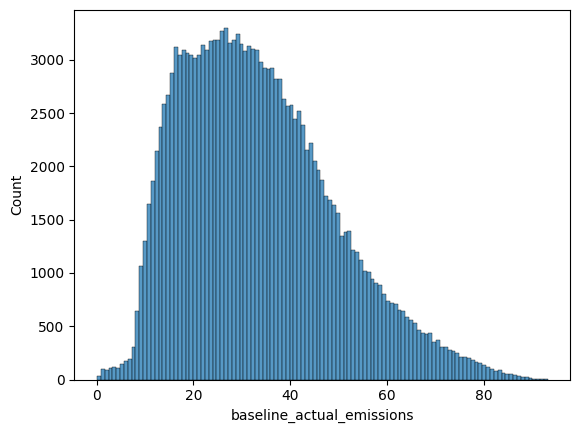

In [20]:
sns.histplot(synth_data['baseline_actual_emissions'])

## MOER - Simple Optimization - Forecast Emissions

In [21]:
%%time

synth_data['charger_simple_forecast']= synth_data.apply(
    lambda x: efu.get_schedule_and_cost(
        x.MWh_fraction,
        x.charged_kWh_actual / 1000,
        math.ceil(x.total_intervals_plugged_in), # will throw an error if the plug in time is too shart to reach full charge, should soften to a warning
        x.moer_data,
        asap = False
        ), 
        axis = 1
        )

synth_data['simple_charing_schedule'] = synth_data['charger_simple_forecast'].apply(
    lambda  x: x.get_schedule()
    )

synth_data['simple_estimated_emissions'] = synth_data['charger_simple_forecast'].apply(
    lambda  x: x.get_total_cost()
    )

CPU times: user 1min 1s, sys: 133 ms, total: 1min 1s
Wall time: 1min 1s


In [22]:
def get_total_emission(moer, schedule): 
    x = np.array(schedule).flatten()
    return np.dot(moer[:x.shape[0]], x)

In [23]:
synth_data["simple_actual_emissions"] = synth_data.apply(
    lambda x: get_total_emission(
        x.moer_data_actual['value'],
        x.simple_charing_schedule,
    ),
    axis = 1
)

<Axes: xlabel='baseline_actual_emissions', ylabel='Count'>

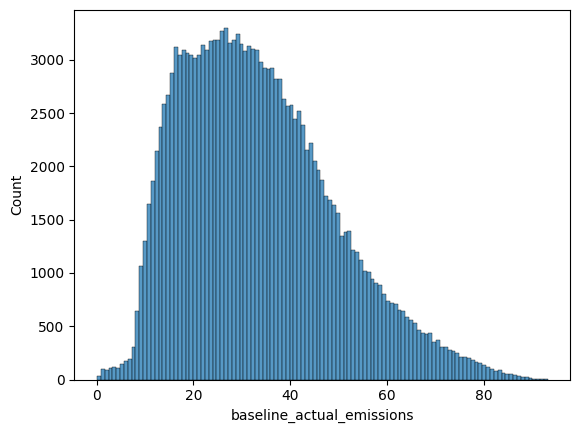

In [26]:
sns.histplot(synth_data["baseline_actual_emissions"])

<Axes: xlabel='simple_actual_emissions', ylabel='Count'>

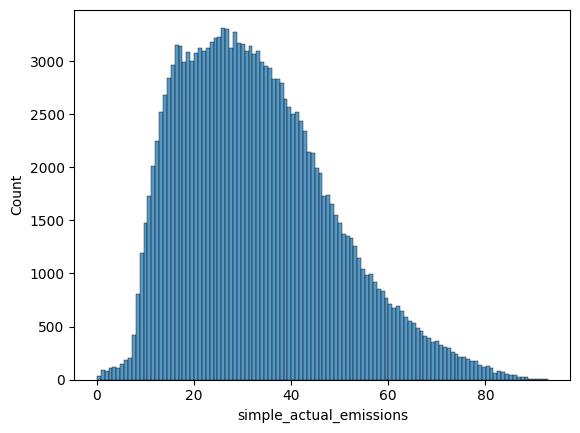

In [27]:
sns.histplot(synth_data["simple_actual_emissions"])

In [28]:
synth_data["simple_optimization_difference"] = synth_data["simple_actual_emissions"] - synth_data["baseline_actual_emissions"]

In [29]:
synth_data["success_rate"] = synth_data["simple_optimization_difference"] < 0

In [30]:
synth_data["success_rate"].value_counts()

success_rate
True     96991
False    66009
Name: count, dtype: int64

---

# store the results

In [51]:
from optimizer.s3 import s3_utils
s3 = s3_utils()
cols = [
    "distinct_dates",
    "plug_in_time",
    "total_intervals_plugged_in",
    "charged_kWh_actual",
    "MWh_fraction",
    "simple_actual_emissions",
    "baseline_actual_emissions",
]
s3.store_csvdataframe(
    synth_data[cols], f"results/20240726_1k_synth_users_163_days_{region}.csv"
)

Successful S3 put_object response. Status - 200
